In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import sys
import pytorch_model_summary
import numpy

print(f'torch : {torch.__version__}')
print(f'python : {sys.version}')

torch : 1.11.0
python : 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]


In [19]:
# Train_data transform

train_transform = transforms.Compose(
    [   
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]
)

batch_size = 128

# data download
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform = train_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size= batch_size,shuffle=True)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle= True)

classes = ('plane','car','bird','cat','deer','dog','frog', 'horse', 'ship', 'truck')

print(f'train_set : {len(train_set)}')
print(f'test_set  : {len(test_set)}')


Files already downloaded and verified
Files already downloaded and verified
train_set : 50000
test_set  : 10000


In [20]:
print(len(train_loader))
a,b= next(iter(train_loader))
print(len(b))
print(a.shape)

391
128
torch.Size([128, 3, 32, 32])


In [21]:
class VGG11(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11,self).__init__()

        #self.features = features
        self.convlayer = nn.Sequential(
            # RGB 3 - > 64 / size(32,32)
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64,out_channels=128, kernel_size=3, padding=1, stride=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels = 256, kernel_size=3, padding=1, stride=1),
            #nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,out_channels=256, kernel_size=3, padding=1, stride=1),
            #nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # size (16, 16)

            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # size (8,8)

            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # size (4,4)

        )

        self.fclayer =nn.Sequential(
            nn.Linear(512*4*4, 4096),
            #nn.BatchNorm1d(4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096,4096),
            #nn.BatchNorm1d(4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096,num_classes)
        )

    def forward(self, x):
        x = self.convlayer(x)
        x = torch.flatten(x,1)
        x = self.fclayer(x)
        return x

In [22]:
vgg11 = VGG11(num_classes=10)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

print(pytorch_model_summary.summary(vgg11,torch.zeros(128,3,32,32),show_input=True))

if device == 'cuda':
    vgg11 = vgg11.to(device)
# summary
#print(vgg11)


Using cuda device
--------------------------------------------------------------------------
      Layer (type)            Input Shape         Param #     Tr. Param #
          Conv2d-1       [128, 3, 32, 32]           1,792           1,792
            ReLU-2      [128, 64, 32, 32]               0               0
          Conv2d-3      [128, 64, 32, 32]          73,856          73,856
            ReLU-4     [128, 128, 32, 32]               0               0
          Conv2d-5     [128, 128, 32, 32]         295,168         295,168
            ReLU-6     [128, 256, 32, 32]               0               0
          Conv2d-7     [128, 256, 32, 32]         590,080         590,080
            ReLU-8     [128, 256, 32, 32]               0               0
       MaxPool2d-9     [128, 256, 32, 32]               0               0
         Conv2d-10     [128, 256, 16, 16]       1,180,160       1,180,160
           ReLU-11     [128, 512, 16, 16]               0               0
         Conv2d-12 

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg11.parameters(), lr = 0.0001)

In [24]:
loss_list = []
acc_list = []
test_acc_list = []
test_loss_list = []
epochs = 40
best_score = 0.0
for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0
    test_loss= 0.0
    start_time = time.time()
    total = 0
    t_total = 0
    correct =0 
    t_correct = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        if device =='cuda':
            inputs = inputs.to(device)
            labels = labels.to(device)
            
        #print(f'i : {i}, labels.shape :{labels.shape}')
        # gradients to zero
        optimizer.zero_grad()

        outputs = vgg11(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _,predicted = torch.max(outputs,1)
        total += labels.size(0)
        running_acc += (predicted == labels).sum().item()
        running_loss += loss.item()

    # test data로 바로 확인
    with torch.no_grad():
        for t_data in test_loader:
            t_images, t_labels = t_data
            if device =='cuda':
                t_images= t_images.to(device)
                t_labels= t_labels.to(device)
            
            t_outputs = vgg11(t_images)
            t_loss = criterion(outputs, labels)

            _, t_predicted = torch.max(t_outputs,1)
            
            t_total += t_labels.size(0)
            t_correct += (t_predicted == t_labels).sum().item()

            test_loss += t_loss.item()
    if best_score < (t_correct/t_total):
        best_score = t_correct/t_total
        torch.save(vgg11,'./models/vgg11.pt')
    print(f'epoch : {epoch+1}, time :{time.time()-start_time:.2f}s')
    print(f'loss : {running_loss/len(train_loader):.3f}, acc: {running_acc/total:.2f}, ',end='')
    print(f'test_loss : {test_loss/len(test_loader):.3f}, test_acc : {t_correct/t_total:.2f}\n')
    loss_list.append(running_loss/len(train_loader))
    acc_list.append(running_acc/total)
    test_loss_list.append(test_loss/len(test_loader))
    test_acc_list.append(t_correct/t_total)

print(f'{"-"*20}\nFinish running\n\n')

epoch : 1, time :60.20s
loss : 1.812, acc: 0.32, test_loss : 1.374, test_acc : 0.45

epoch : 2, time :60.64s
loss : 1.391, acc: 0.49, test_loss : 1.119, test_acc : 0.55

epoch : 3, time :60.76s
loss : 1.170, acc: 0.58, test_loss : 1.280, test_acc : 0.63

epoch : 4, time :60.97s
loss : 0.998, acc: 0.65, test_loss : 0.870, test_acc : 0.68

epoch : 5, time :60.64s
loss : 0.870, acc: 0.69, test_loss : 0.915, test_acc : 0.72

epoch : 6, time :60.87s
loss : 0.765, acc: 0.73, test_loss : 0.658, test_acc : 0.75

epoch : 7, time :60.78s
loss : 0.683, acc: 0.76, test_loss : 0.619, test_acc : 0.78

epoch : 8, time :60.74s
loss : 0.614, acc: 0.78, test_loss : 0.433, test_acc : 0.78

epoch : 9, time :60.92s
loss : 0.564, acc: 0.80, test_loss : 0.677, test_acc : 0.79

epoch : 10, time :60.95s
loss : 0.510, acc: 0.82, test_loss : 0.561, test_acc : 0.80

epoch : 11, time :60.89s
loss : 0.468, acc: 0.84, test_loss : 0.479, test_acc : 0.81

epoch : 12, time :60.91s
loss : 0.427, acc: 0.85, test_loss : 0

In [25]:
best=torch.load('./models/vgg11.pt')
correct = 0
total = 0
class_correct = {classname : 0 for classname in classes}
class_total = {classname : 0 for classname in classes}
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        if device =='cuda':
            images= images.to(device)
            labels= labels.to(device)
        
        outputs = best(images)
        _, predicted = torch.max(outputs,1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for label, predict in zip(labels,predicted):
            if label == predict:
                class_correct[classes[label]] +=1
            class_total[classes[label]] +=1

print(f'Total Accuracy : {100* correct /total:.1f}%\n')

for classname, number in class_correct.items():
    print(f'Accuray of {classname} : {100*number/class_total[classname]:.1f}%')

Total Accuracy : 85.4%

Accuray of plane : 88.4%
Accuray of car : 94.4%
Accuray of bird : 79.8%
Accuray of cat : 71.1%
Accuray of deer : 84.2%
Accuray of dog : 78.3%
Accuray of frog : 88.0%
Accuray of horse : 90.5%
Accuray of ship : 89.5%
Accuray of truck : 89.4%


In [26]:
# 확인 하기 , input과 output의 데이터
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        if device =='cuda':
            images= images.to(device)
            labels= labels.to(device)
        
        outputs = vgg11(images)
        _, predicted = torch.max(outputs,1)
        print(f'predicted : {predicted}, size : {predicted.shape}')
        print(f'images : {images.shape}')
        print(f'labels : {labels.shape}')
        print(f'labels.size(0) : {labels.size(0)}')
        break

predicted : tensor([1, 6, 4, 4, 7, 4, 9, 6, 8, 4, 8, 8, 5, 9, 6, 2, 7, 5, 5, 7, 5, 4, 1, 3,
        3, 1, 0, 8, 4, 0, 4, 6, 7, 1, 3, 8, 9, 2, 1, 3, 3, 8, 6, 7, 1, 2, 5, 1,
        8, 8, 9, 2, 6, 2, 2, 0, 6, 9, 1, 2, 8, 8, 9, 1, 2, 0, 1, 5, 3, 6, 3, 2,
        3, 9, 5, 4, 0, 4, 0, 3, 9, 7, 3, 3, 6, 2, 5, 3, 2, 0, 6, 4, 5, 4, 0, 0,
        8, 7, 4, 4, 3, 3, 7, 8, 6, 7, 7, 9, 9, 0, 7, 7, 0, 1, 4, 4, 9, 1, 3, 9,
        2, 4, 6, 3, 7, 6, 9, 5], device='cuda:0'), size : torch.Size([128])
images : torch.Size([128, 3, 32, 32])
labels : torch.Size([128])
labels.size(0) : 128


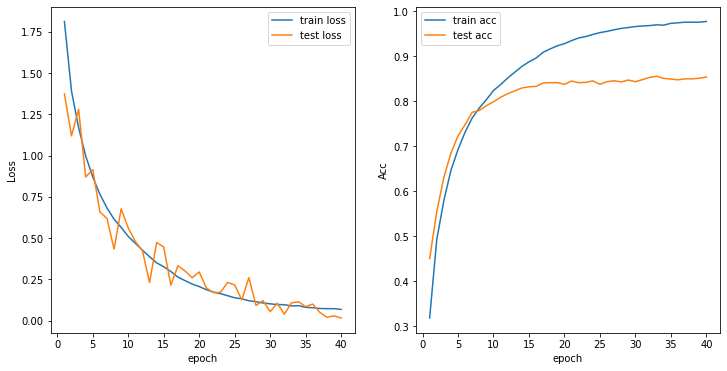

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(1,epochs+1),loss_list,label='train loss')
plt.plot(range(1,epochs+1),test_loss_list,label='test loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,epochs+1),acc_list,label='train acc')
plt.plot(range(1,epochs+1),test_acc_list,label='test acc')
plt.xlabel('epoch')
plt.ylabel('Acc')
plt.legend()

plt.show()